In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

In [2]:
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
dataset = pd.read_csv("../data/train_simple.csv")
dataset.shape

In [4]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [5]:
dataset.isna().sum().sum()

0

## **Описание задачи**

Предсказание цены коммерческой недвижимости. Оценка вручную занимает много времени (долгая оценка = задержка решения по выдаче кредита → можно потерять клиента), зато есть много данных по оценке стоимости недвижимости из объявлений в интернете. Предлагается сравнить эти 2 группы наблюдений.

In [6]:
target = "per_square_meter_price"
treatment = "price_type"
feature_columns = [
    'city_population',
    'total_square',
    'osm_catering_points_in_0.005',
    'region',
    'floor',
    'realty_type',
    'osm_crossing_closest_dist',
    'osm_city_nearest_name',
    'osm_subway_closest_dist',
    'reform_mean_floor_count_1000',
    'osm_transport_stop_closest_dist',
    'osm_amenity_points_in_0.001',
    'osm_city_nearest_population',
    'lng',
    'osm_city_closest_dist',
    'osm_crossing_points_in_0.005',
    'floor_type',
    'lat',
    'reform_mean_year_building_500',
    'osm_culture_points_in_0.005',
    'reform_house_population_500',
]

In [7]:
xs = ""
for i in feature_columns:
    xs += (str(i)+"+")
common_causes = xs.split('+')

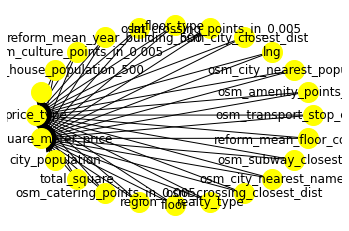

In [8]:
xs = ""
for i in feature_columns:
    xs += (str(i)+"+")

model = CausalModel(
    data=dataset,
    treatment=treatment,
    outcome=target,
    common_causes=common_causes
)

model.view_model()

### Step 2. Identification (formulating what to estimate)

In [9]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(per_square_meter_price|reform_mean_floor_count_1000,
d[price_type]                                                                 

                                                                              
realty_type,lng,osm_crossing_closest_dist,osm_catering_points_in_0.005,osm_tra
                                                                              

                                                                              
nsport_stop_closest_dist,floor_type,osm_crossing_points_in_0.005,floor,osm_cul
                                                                              

                                                                              
ture_points_in_0.005,reform_house_population_500,osm_city_closest_dist,osm_sub
                                

### Step 3. Estimation (compute the estimate)

In [10]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression", #"backdoor.propensity_score_stratification",
    target_units="ate"
)
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(per_square_meter_price|reform_mean_floor_count_1000,
d[price_type]                                                                 

                                                                              
realty_type,lng,osm_crossing_closest_dist,osm_catering_points_in_0.005,osm_tra
                                                                              

                                                                              
nsport_stop_closest_dist,floor_type,osm_crossing_points_in_0.005,floor,osm_cul
                                                                              

                                                                              
ture_points_in_0.005,reform_house_population_500,osm_city_close

### Refute

In [11]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the 
# causal estimate changes or not. If our assumption was originally correct then 
# the causal estimate shouldn’t change by much.

refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause"
)
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-30541.034409304106
New effect:-30538.501855510418



In [12]:
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.
res_placebo = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute"
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-30541.034409304106
New effect:224.3920388275309
p value:0.47



In [13]:
#Creates subsets of the data(similar to cross-validation) and checks whether the 
# causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.
res_subset = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.9
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-30541.034409304106
New effect:-30567.341838824053
p value:0.49

